
##使用Metpy繪製近實時既GFS圖

## Installation

首先要install anaconda navigator
開啟Jupyter lab
之後響cmd 果度打conda install ......
以下requirement 是需要的:
matplotlib
numpy
pandas
pint
pooch
pyproj
scipy
traitlets
xarray
最重要係metpy

In [ ]:
#import python package
from datetime import datetime, timedelta

import urllib.request
import matplotlib.pyplot as plt

import xarray as xr
from metpy.calc import wind_components
import metpy.calc as mpcalc
from metpy.io import metar
from metpy.plots.declarative import (BarbPlot, ContourPlot, FilledContourPlot, MapPanel,
                                     PanelContainer, PlotObs)

from metpy.units import units
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from metpy.io import metar
from metpy.cbook import get_test_data

## 取得GFS data

GFS既data store 係一個DATABASE度，https://thredds.ucar.edu/thredds/catalog/idd/forecastModels.html
，而我地既目標係plot近實時既GFS圖，所以可以去呢個網址度搵下->Quarter degree forecast->最新既grib2 file->openDAP 2->然後就會見到一大堆GFS Dataset variable 會用到。我地既目標就係用python plot 呢d Dataset 既 variable。



In [ ]:
run_date = "20250225"#YYYYMMDD年月日
init = "1800"#時間,只可以0000,0600,1200或者1800
#url=f'https://tds.scigw.unidata.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_{run_date}_{init}.grib2'#Dataset既網址優先度第2
#GFS 0.25 resolution
url = f"http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_{run_date}_{init}.grib2"#Dataset既網址優先度第1
#GFS 1 resolution
#url=f"https://tds.scigw.unidata.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_onedegree_noaaport/GFS_Global_onedeg_noaaport_20240620_0600.grib2"
#舊版GFS
#url=f"https://tds.scigw.unidata.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_onedeg/GFS_Global_onedeg_20240621_0000.grib2"
#WW3（Wave watch 3)
#url=f"https://tds.scigw.unidata.ucar.edu/thredds/dodsC/grib/NCEP/WW3/Global/WW3_Global_{run_date}_{init}.grib2"
data = xr.open_dataset(url)#store 個dataset 做一個variable叫做data

In [ ]:
ds = data.metpy.sel(lat=slice(36, 7), lon=slice(100, 140))#選取要plot既範圍,呢個example既latitude係由北緯7-36N，東經100-140E

In [ ]:
#ds = data.metpy.sel(lat=slice(30, 0), lon=slice(360-100, 360-40))#呢個係西半球既例子

## Set Datetime

呢個係set個plot time


In [ ]:
plot_time = datetime(2025,2,25,18)+timedelta(hours=384)

## Subsetting Data

MetPy provides wrappers for the usual xarray indexing and selection routines that can handle
quantities with units. For DataArrays, MetPy also allows using the coordinate axis types
mentioned above as aliases for the coordinates. And so, if we wanted data to be just over
the U.S. for plotting purposes



For full details on xarray indexing/selection, see
[xarray's documentation](https://docs.xarray.dev/en/stable/indexing.html).



## Calculations

In MetPy 1.0 and later, calculation functions accept Xarray DataArray's as input and the
output a DataArray that can be easily added to an existing Dataset.

As an example, we calculate wind speed from the wind components and add it as a new variable
to our Dataset.



In [67]:
ds['wind_speed'] = mpcalc.wind_speed(ds['u-component_of_wind_height_above_ground'],
                                     ds['v-component_of_wind_height_above_ground'])

## Plotting

With that minimal preparation, we are now ready to use the simplified plotting syntax to be
able to plot our data and analyze the meteorological situation.

General Structure

1. Set contour attributes

2. Set map characteristics and collect contours

3. Collect panels and plot

4. Show (or save) the results

Valid Plotting Types for Gridded Data:

- ``ContourPlot()``

- ``FilledContourPlot()``

- ``ImagePlot()``

- ``BarbPlot()``

More complete descriptions of these and other plotting types, as well as the map panel and
panel container classes are at the end of this tutorial.

Let's plot a 300-hPa map with color-filled wind speed, which we calculated and added to
our Dataset above, and geopotential heights over the CONUS.



We'll start by setting attributes for contours of Geopotential Heights at 300 hPa.
We need to set at least the data, field, level, and time attributes. We'll set a few others
to have greater control over hour the data is plotted.



In [83]:
# Set attributes for contours of Geopotential Heights at 300 hPa
cntr2 = ContourPlot()
cntr2.data = ds
cntr2.field = 'MSLP_Eta_model_reduction_msl'
cntr2.time = plot_time
cntr2.contours = list(range(850, 1041, 2))
cntr2.linecolor = 'black'
cntr2.linestyle = 'solid'
cntr2.linewidth = 1
cntr2.clabels = True
cntr2.plot_units='hPa'

In [76]:
cntr3=ContourPlot()
cntr3.data = ds
cntr3.field = 'Wind_speed_surface'
cntr3.time = plot_time
cntr3.contours = list(range(0,81,5))
cntr3.linecolor = 'black'
cntr3.linestyle = 'solid'
cntr3.clabels = True
cntr3.plot_units='knots'

In [31]:
# Set attributes for plotting color-filled contours of wind speed at 300 hPa
cntr4 = ContourPlot()
cntr4.data = ds
cntr4.field = 'wind_speed' 
cntr4.time = plot_time
cntr4.level=10*units.m
cntr4.contours = list((range( 0,81,5)))
cntr4.linecolor = 'red'
cntr4.linestyle ='solid'
cntr4.clabels=True
cntr4.plot_units = 'knots'

In [67]:
cntr5 = ContourPlot()
cntr5.data = ds
cntr5.field = 'Geopotential_height_isobaric' 
cntr5.time = plot_time
cntr5.level=500*units.hPa
cntr5.contours = list((range(5600,6000,20)))
cntr5.linecolor = 'red'
cntr5.linestyle ='solid'
cntr5.clabels=True
cntr5.plot_units = 'gpm'

Now we'll set the attributes for plotting color-filled contours of wind speed at 300 hPa.
Again, the attributes that must be set include data, field, level, and time. We'll also set
a colormap and colorbar to be purposeful for wind speed. Additionally, we'll set the
attribute to change the units from m/s to knots, which is the common plotting units for
wind speed.



In [84]:
# Set attributes for plotting color-filled contours of wind speed at 300 hPa
cfill = FilledContourPlot()
cfill.data = ds
cfill.field = 'wind_speed' 
cfill.time = plot_time
cfill.level=10*units.m
cfill.contours = list((range( 0,101,5)))
cfill.image_range=(0,101)
cfill.colormap = 'gist_ncar'
cfill.colorbar = 'horizontal'
cfill.plot_units = 'knots'

In [32]:
cfill = FilledContourPlot()
cfill.data = ds
cfill.field = 'MSLP_Eta_model_reduction_msl' 
cfill.time = plot_time
cfill.level=None
cfill.contours = list((range( 850,1030,5)))
cfill.image_range=(850,1030)
cfill.colormap = 'gist_ncar'
cfill.colorbar = 'horizontal'
cfill.plot_units = 'hPa'

In [77]:
cfill = FilledContourPlot()
cfill.data = ds
cfill.field = 'Wind_speed_surface'
cfill.colormap = 'gist_ncar'
cfill.time=plot_time
cfill.colorbar = 'horizontal'
cfill.plot_units='knots'
cfill.contours = list((range(0,81,5)))

In [68]:
cfill2=FilledContourPlot()
cfill2.data=ds
cfill2.field='Geopotential_height_isobaric'
cfill2.contours = list((range( 5600,6000,20)))
cfill2.time=plot_time
cfill2.plot_units='gpm'
cfill2.level=500*units.hPa
cfill2.colormap='nipy_spectral'
cfill2.colorbar='horizontal'

Once we have our contours (and any colorfill plots) set up, we will want to define the map
panel that we'll plot the data on. This is the place where we can set the view extent,
projection of our plot, add map lines like coastlines and states, set a plot title.
One of the key elements is to add the data to the map panel as a list with the plots
attribute.



In [85]:
# Set attributes for plotting wind barbs
barbs = BarbPlot()
barbs.data = ds
barbs.time = plot_time
#barbs.field=['u-component_of_wind_surface','v-component_of_wind_surface']
#barbs.field = ['u-component_of_wind_isobaric', 'v-component_of_wind_isobaric']
barbs.field=['u-component_of_wind_height_above_ground','v-component_of_wind_height_above_ground']
barbs.level = 10*units.m
barbs.skip = (5,5)
barbs.plot_units = 'knots'
barbs.color='red'

In [89]:
# Set the attributes for the map and add our data to the map
panel = MapPanel()
panel.area = [100,140,7,36]
panel.projection = 'mer'
panel.layers = ['states', 'coastline', 'borders']
panel.layers_edgecolor='white'
panel.title=f'GFS 0.25 resolution 10m wind speed with isobar at {plot_time} Z,{run_date}{init}Z run'"\n"f' Minimum pressure:{float(np.min(ds.MSLP_Eta_model_reduction_msl[128]/100))}hPa'"\n"f'Maximum 10m wind speed:{float(np.max(cfill.data.wind_speed[128][0]*3.6/1.852))}kts'"\n"f'Maximum 100m wind speed:{float(np.max(cfill.data.wind_speed[128][6]*3.6/1.852))}kts'"\n"f'Max surface wind gust:{float(np.max(ds.Wind_speed_gust_surface[128]*3.6/1.852))}kts'"\n"f'cheung chau 10m wind:{float(cfill.data.wind_speed[128][0][31][56]*3.6/1.852)}kts'
#panel.title=f'GFS-AVN 10m wind speed at {plot_time} Z,{run_date}{init}Z run,'"\n"f' Minimum pressure:{float(np.min(ds.MSLP_Eta_model_reduction_msl[22]/100))}hPa,'"\n"f'Maximum 10m wind speed:{float(np.max(cfill.data.wind_speed[22][0]*3.6/1.852))}kts,'"\n"f'southern water near HK 10m wind:{float(cfill.data.wind_speed[22][0][8][14]*3.6/1.852)}kts'
#panel.title = f' 0.5 resolution surface wind speed at {plot_time} Z,{run_date}{init}Z run,'"\n"f' Minimum pressure:{float(np.min(ds.MSLP_Eta_model_reduction_msl[52]/100))}hPa,'"\n"f'Maximum 10m wind speed:{float(np.max(cfill.data.wind_speed[52][6]*3.6/1.852))}kts,'"\n"f'cheung chau 10m wind:{float(cfill.data.wind_speed[52][6][31][56]*3.6/1.852)}kts'
#panel.title = f'WW3 0.5 resolution surface wind speed at {plot_time}Z, {run_date}{init}Z run,'"\n"f'Maximum intensity in this run:{float(np.max(cfill.data.Wind_speed_surface[0:42]*3.6/1.852))}kts'
panel.plots=[cfill,cntr2,barbs]

In [90]:
pc = PanelContainer()
pc.size = (10,10)
pc.panels=[panel]

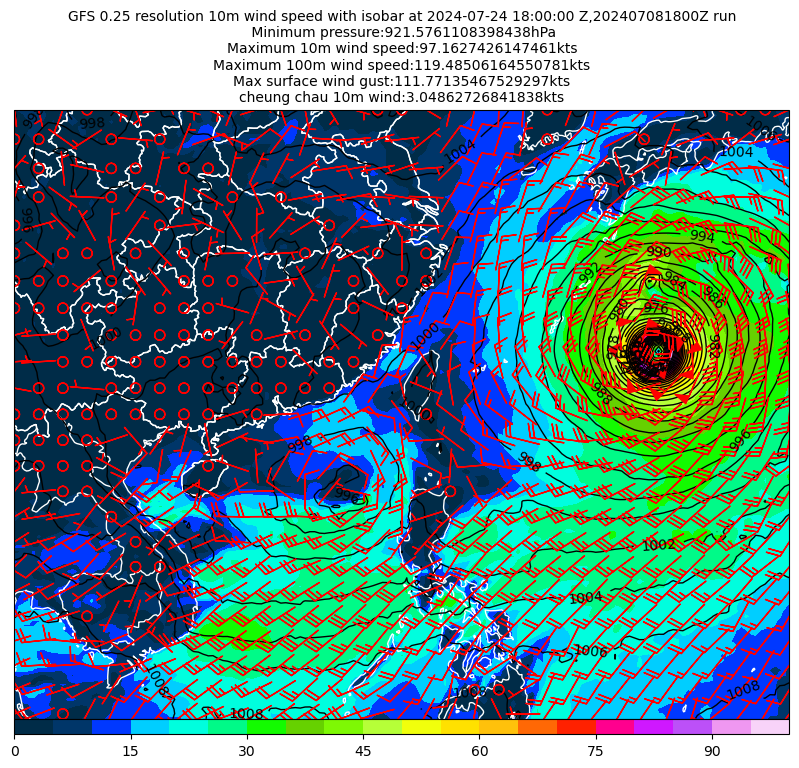

In [91]:
pc.show()

Finally we'll collect all the panels to plot on the figure, set the size of the figure,
and ultimately show or save the figure.



All of our setting now produce the following map!



In [83]:
panel = MapPanel()
panel.area = [100, 130, 10, 30]
panel.projection = 'mer'
panel.layers = ['states', 'coastline', 'borders']
panel.layers_edgecolor='green'
panel.title = f'{barbs.level.m}-hPa Wind Speed color/contour(blue),MSLP contour(red) at {plot_time}Z ,{run_date}{init}Z run'
panel.plots = [cfill,cntr3,barbs]

In [84]:
pc = PanelContainer()
pc.size = (15,15)
pc.panels=[panel]

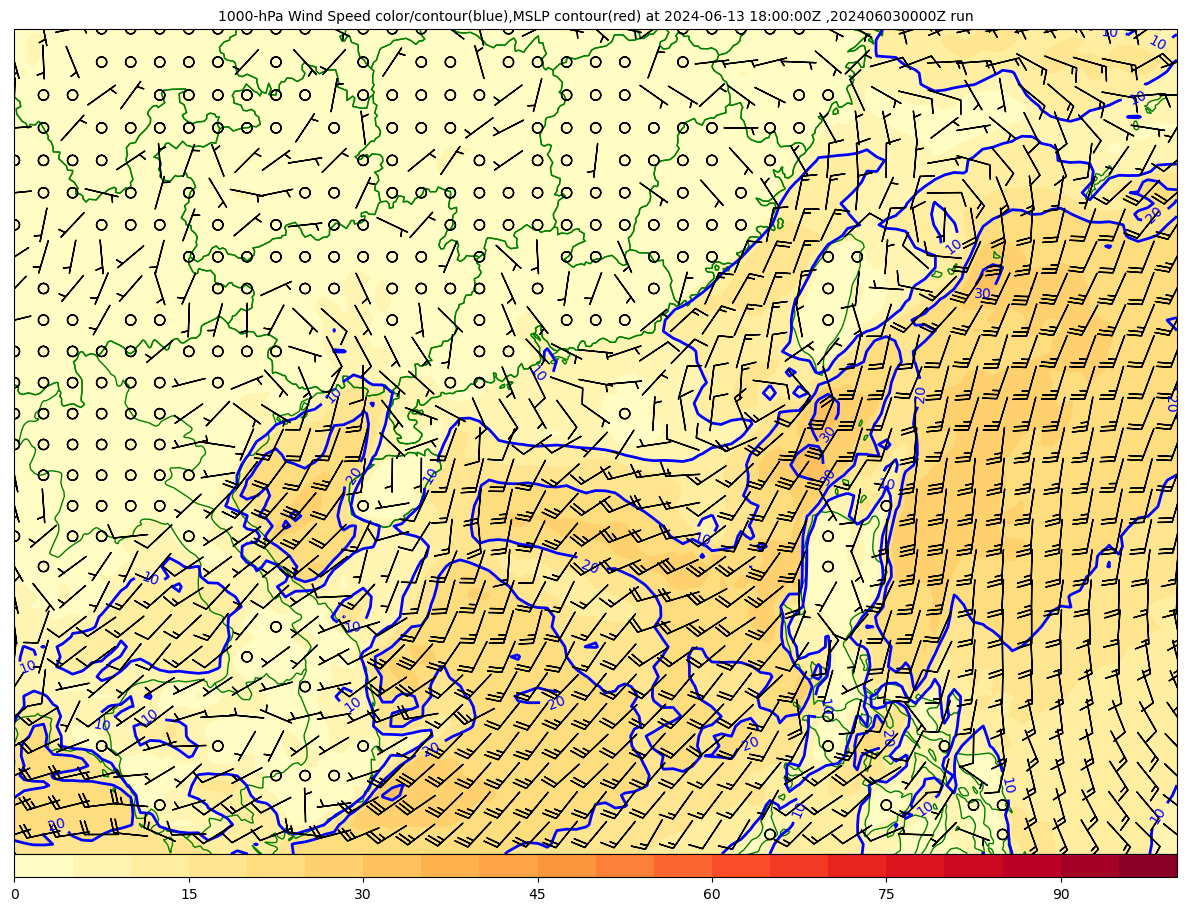

In [85]:
# Show the image
pc.show()

That's it! What a nice looking map, with relatively simple set of code.



## Adding Wind Barbs

We can easily add wind barbs to the plot we generated above by adding another plot type
and adding it to the panel. The plot type for wind barbs is ``BarbPlot()`` and has its own
set of attributes to control plotting a vector quantity.



We start with setting the attributes that we had before for our 300 hPa plot including,
Geopotential Height contours, and color-filled wind speed.



In [216]:
#cntr2.level = 1000* units.hPa

# Set attributes for contours of Geopotential Heights at 300 hPa
cntr2 = ContourPlot()
cntr2.data = ds
cntr2.field = 'wind_speed'
cntr2.time = plot_time
cntr2.contours = list((range(0, 101, 10)))
cntr2.linecolor = 'blue'
cntr2.linestyle = 'solid'
cfill.plot_units = 'knots'

# Set attributes for plotting color-filled contours of wind speed at 300 hPa
cfill = FilledContourPlot()
cfill.data = ds
cfill.field = 'wind_speed'
cfill.level = 1000 * units.hPa
cfill.time = plot_time
cfill.contours = list((range(0, 101, 5)))
cfill.colormap = 'YlOrRd'
cfill.colorbar = 'horizontal'
cfill.plot_units = 'knots'

Now we'll set the attributes for plotting wind barbs, with the required attributes of data,
time, field, and level. The skip attribute is particularly useful for thinning the number of
wind barbs that are plotted on the map. Again we convert to units of knots.



In [217]:
# Set attributes for plotting wind barbs
barbs = BarbPlot()
barbs.data = ds
barbs.time = plot_time
barbs.field = ['u-component_of_wind_isobaric', 'v-component_of_wind_isobaric']
barbs.level = 1000 * units.hPa
barbs.skip = (3, 3)
barbs.plot_units = 'knots'

Add all of our plot types to the panel, don't forget to add in the new wind barbs to our plot
list!



ValueError: Must provide a combination of subsetting values to give either 2D data or 3D data subset for plotting with third dimension size 3 or 4

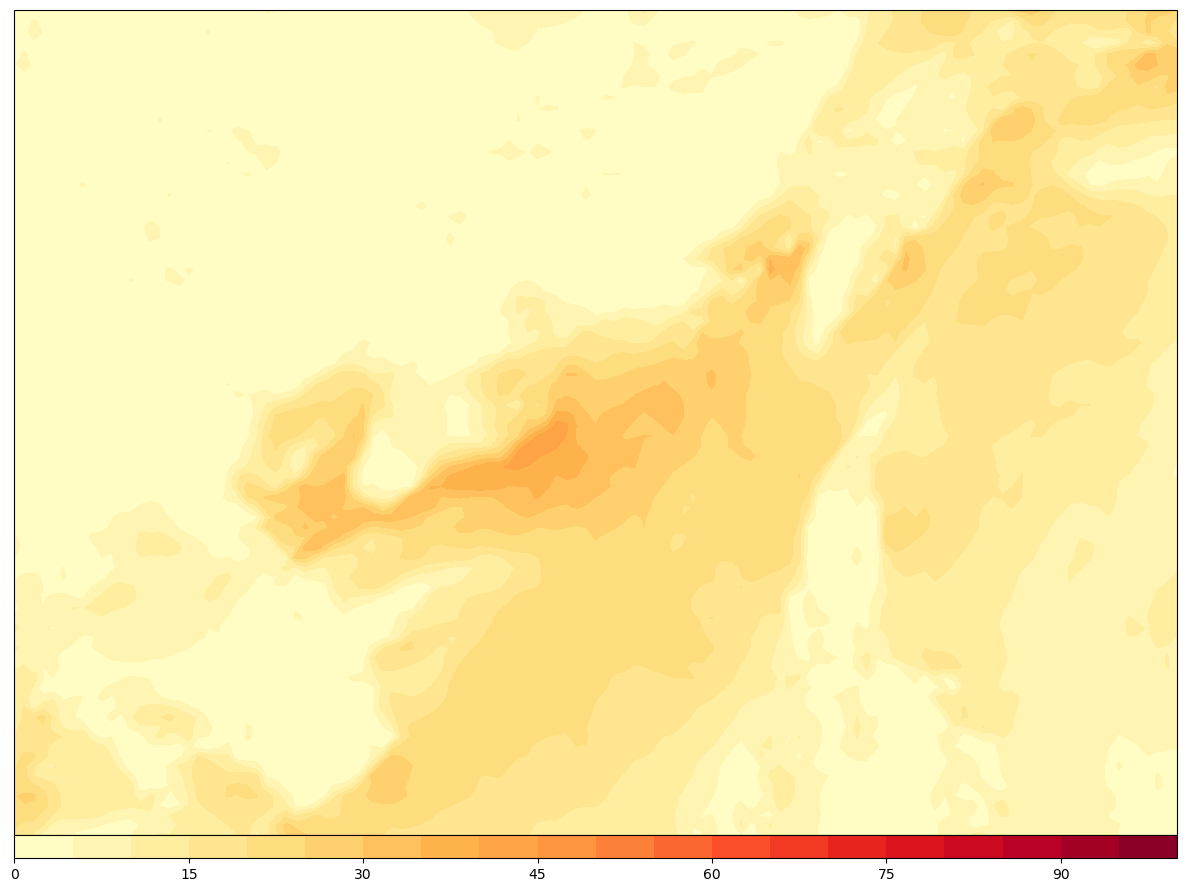

In [218]:
# Set the attributes for the map and add our data to the map
panel = MapPanel()
panel.area = [100, 130, 10, 30]
panel.projection = 'mer'
panel.layers = ['states', 'coastline', 'borders']
panel.layers_edgecolor='green'
panel.title = f'{cfill.level.m}-hPa Heights and Wind Speed at {plot_time}'
panel.plots = [cfill, cntr2, barbs]

# Set the attributes for the panel and put the panel in the figure
pc = PanelContainer()
pc.size = (15, 15)
pc.panels = [panel]

# Show the figure
pc.show(plot)

## Plot Surface Obs

We can also plot surface (or upper-air) observations at point locations using the simplified
syntax. Whether it is surface or upper-air data, the ``PlotObs()`` class is what you would
want to use. Then you would add those observations to a map panel and then collect the panels
to plot the figure; similar to what you would do for a gridded plot.



In [11]:
url_2=f"metar_20240627_0000.txt"
df = metar.parse_metar_file(get_test_data(url_2,False), year=2024,month=6)

# Let's take a look at the variables that we could plot coming from our METAR observations.
print(df.keys())

# Set the observation time
obs_time = datetime(2024,6,26,0)

ValueError: File 'metar_20240627_0000.txt' is not in the registry.

Setting of our attributes for plotting observations is pretty straightforward and just needs
to be lists for the variables, and a comparable number of items for plot characteristics that
are specific to the individual fields. For example, the locations around a station plot, the
plot units, and any plotting formats would all need to have the same number of items as the
fields attribute.

Plotting wind bards is done through the vector_field attribute. You can reduce the number
of points plotted (especially important for surface observations) with the ``reduce_points``
attribute.

For a very basic plot of one field, the minimum required attributes are the data, time,
fields, and location attributes.



In [64]:
# Plot desired data
obs = PlotObs()
obs.data = df
obs.time = obs_time
obs.time_window = timedelta(minutes=15)
obs.level = None
obs.fields = ['cloud_coverage', 'air_temperature', 'dew_point_temperature',
              'air_pressure_at_sea_level', 'current_wx1_symbol']
obs.plot_units = [None, 'degF', 'degF', None, None]
obs.locations = ['C', 'NW', 'SW', 'NE', 'W']
obs.formats = ['sky_cover', None, None, lambda v: format(v * 10, '.0f')[-3:],
               'current_weather']
obs.reduce_points = 0.75
obs.vector_field = ['eastward_wind', 'northward_wind']

We use the same Classes for plotting our data on a map panel and collecting all the
panels on the figure. In this case we'll focus in on the state of Indiana for plotting.



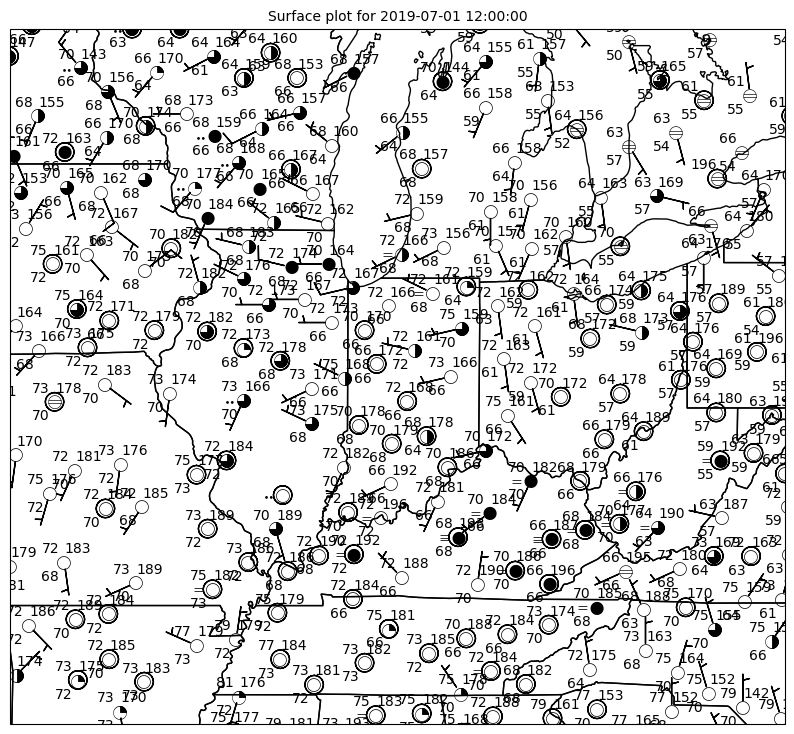

In [65]:
# Panel for plot with Map features
panel = MapPanel()
panel.layout = (1, 1, 1)
panel.projection = 'mer'
panel.area = 'in'
panel.layers = ['states']
panel.title = f'Surface plot for {obs_time}'
panel.plots = [obs]

# Bringing it all together
pc = PanelContainer()
pc.size = (10, 10)
pc.panels = [panel]

pc.show()

## Detailed Attribute Descriptions

This final section contains verbose descriptions of the attributes that can be set by the
plot types used in this tutorial.



## ContourPlot()

This class is designed to plot contours of gridded data, most commonly model output from the
GFS, NAM, RAP, or other gridded dataset (e.g., NARR).

Attributes:

``data``

This attribute must be set with the variable name that contains the xarray dataset.
(Typically this is the variable ds)

``field``

This attribute must be set with the name of the variable that you want to contour.
For example, to plot the heights of pressure surfaces from the GFS you would use the name
``‘Geopotential_height_isobaric’``

``level``

This attribute sets the level of the data you wish to plot. If it is a pressure level,
then it must be set to a unit bearing value (e.g., 500*units.hPa). If the variable does
not have any vertical levels (e.g., mean sea-level pressure), then the level attribute must
be set to None.

``time``

This attribute must be set with a datetime object, just as with the ``PlotObs()`` class.
To get a forecast hour, you can use the timedelta function from datetime to add the number of
hours into the future you wish to plot. For example, if you wanted the six hour forecast from
the 00 UTC 2 February 2020 model run, then you would set the attribute with:

``datetime(2020, 2, 2, 0) + timedelta(hours=6)``

``contours``

This attribute sets the contour values to be plotted with a list. This can be set manually
with a list of integers in square brackets (e.g., ``[5400, 5460, 5520, 5580, 5640, 5700]``)
or programmatically (e.g., ``list(range(0, 10000, 60))``). The second method is a way to
easily set a contour interval (in this case 60).

``clabel``

This attribute can be set to ``True`` if you desire to have your contours labeled.

``linestyle``

This attribute can be set to make the contours ``‘solid’``, ``‘dashed’``, ``‘dotted’``,
or ``‘dashdot’``. Other linestyles are can be used and are found at:
https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html

Default is ``‘solid’``.

``linewidth``

This attribute alters the width of the contours (defaults to 1). Setting the value greater
than 1 will yield a thicker contour line.

``linecolor``

This attribute sets the color of the contour lines. Default is ``‘black’``. All colors from
matplotlib are valid: https://matplotlib.org/3.1.0/_images/sphx_glr_named_colors_003.png

``plot_units``

If you want to change the units for plotting purposes, add the string value of the units
desired. For example, if you want to plot temperature in Celsius, then set this attribute
to ``‘degC’``.

``scale``

This attribute will scale the field by multiplying by the scale. For example, to
scale vorticity to be whole values for contouring you could set the scale to 1e5, such that
the data values will be multiplied by 10^5.



## FilledContourPlot()

Works very similarly to ``ContourPlot()``, except that contours are filled using a colormap
between contour values. All attributes for ``ContourPlot()`` work for color-filled plots,
except for linestyle, linecolor, and linewidth. Additionally, there are the following
attributes that work for color-filling:

Attributes:

``colormap``

This attribute is used to set a valid colormap from either Matplotlib or MetPy:
Matplotlib Colormaps: https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
MetPy Colormaps: https://unidata.github.io/MetPy/v1.0/api/generated/metpy.plots.ctables.html

``colorbar``

This attribute can be set to ``‘vertical’`` or ``‘horizontal’``, which is the location the
colorbar will be plotted on the panel.

``image_range``

A set of values indicating the minimum and maximum for the data being plotted. This
attribute should be set as ``(min_value, max_value)``, where min_value and max_value are
numeric values.



## PanelContainer()

Attributes:

``size``

The size of the figure in inches (e.g., (10, 8))

``panels``

A list collecting the panels to be plotted in the figure.

``show``

Show the plot

``save``

Save the figure using the Matplotlib arguments/keyword arguments



## MapPanel()

Attributes:

``layout``

The Matplotlib layout of the figure. For a single panel figure the setting should be
``(1, 1, 1)``

``projection``

The projection can be set with the name of a default projection (``‘lcc’``, ``‘mer’``, or
``‘ps’``) or it can be set to a Cartopy projection.

``layers``

This attribute will add map layers to identify boundaries or features to plot on the map.
Valid layers are ``'borders'``, ``'coastline'``, ``'states'``, ``'lakes'``, ``'land'``,
``'ocean'``, ``'rivers'``, ``'counties'``.

``area``

This attribute sets the geographical area of the panel. This can be set with a predefined
name of an area including all US state postal abbreviations (e.g., ``‘us’``, ``‘natl’``,
``‘in’``, ``‘il’``, ``‘wi’``, ``‘mi’``, etc.) or a tuple value that corresponds to
longitude/latitude box based on the projection of the map with the format
``(west-most longitude, east-most longitude, south-most latitude, north-most latitude)``.
This tuple defines a box from the lower-left to the upper-right corner.

``title``

This attribute sets a title for the panel.

``plots``

A list collecting the observations to be plotted in the panel.



## BarbPlot()

This plot class is used to add wind barbs to the plot with the following

Attributes:

``data``

This attribute must be set to the variable that contains the vector components to be plotted.

``field``

This attribute is a list of the vector components to be plotted. For the typical
meteorological case it would be the ``[‘u-component’, ‘v-component’]``.

``time``

This attribute should be set to a datetime object, the same as for all other declarative
classes.

``barblength``

This attribute sets the length of the wind barbs. The default value is based on the
font size.

``color``

This attribute sets the color of the wind barbs, which can be any Matplotlib color.
Default color is ``‘black’``.

``earth_relative``

This attribute can be set to False if the vector components are grid relative (e.g., for NAM
or NARR output)

``pivot``

This attribute can be set to a string value about where the wind barb will pivot relative to
the grid point. Possible values include ``‘tip’`` or ``‘middle’``. Default is ``‘middle’``.



## PlotObs()

This class is used to plot point observations from the surface or upper-air.

Attributes:

``data``

This attribute needs to be set to the DataFrame variable containing the fields that you
desire to plot.

``fields``

This attribute is a list of variable names from your DataFrame that you desire to plot at the
given locations around the station model.

``level``

For a surface plot this needs to be set to None.

``time``

This attribute needs to be set to subset your data attribute for the time of the observations
to be plotted. This needs to be a datetime object.

``locations``

This attribute sets the location of the fields to be plotted around the surface station
model. The default location is center ``(‘C’)``

``time_window``

This attribute allows you to define a window for valid observations (e.g., 15 minutes on
either side of the datetime object setting. This is important for surface data since actual
observed times are not all exactly on the hour. If multiple observations exist in the defined
window, the most recent observations is retained for plotting purposes.

``formats``

This attribute sets a formatter for text or plotting symbols around the station model. For
example, plotting mean sea-level pressure is done in a three-digit code and a formatter can
be used to achieve that on the station plot.

MSLP Formatter: ``lambda v: format(10 * v, '.0f')[-3:]``

For plotting symbols use the available MetPy options through their name. Valid symbol formats
are ``'current_weather'``, ``'sky_cover'``, ``'low_clouds'``, ``'mid_clouds'``,
``'high_clouds'``, and ``'pressure_tendency'``.

``colors``

This attribute can change the color of the plotted observation. Default is ``‘black’``.
Acceptable colors are those available through Matplotlib:
https://matplotlib.org/3.1.1/_images/sphx_glr_named_colors_003.png

``vector_field``

This attribute can be set to a list of wind component values for plotting
(e.g., ``[‘uwind’, ‘vwind’]``)

``vector_field_color``

Same as colors except only controls the color of the wind barbs. Default is ``‘black’``.

``reduce_points``

This attribute can be set to a real number to reduce the number of stations that are plotted.
Default value is zero (e.g., no points are removed from the plot).

